In [342]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from pytesseract import pytesseract
import easyocr
import imutils
pytesseract.tesseract_cmd = '/Users/alexeidelgado/miniconda3/bin/tesseract'


In [362]:
image = cv2.imread('./images/placa.png')

In [363]:
def plotImages(img1, img2, title1='Imagen Original', title2='Imagen Modificada', cmap2='gray'):
    plt.figure(figsize=(10, 5))

    # Original Image
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
    plt.title(title1)
    plt.axis('off')

    # Modified Image
    plt.subplot(1, 2, 2)
    plt.imshow(img2, cmap=cmap2)
    plt.title(title2)
    plt.axis('off')

    plt.show()

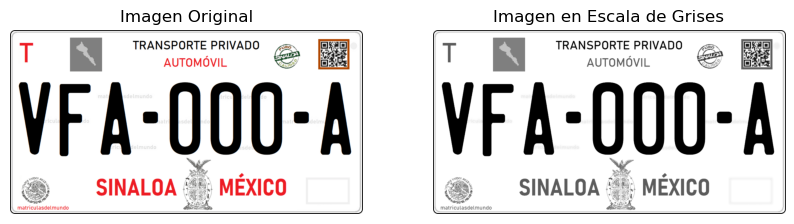

In [364]:
def grayscale(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    bfilter = cv2.bilateralFilter(gray_image, 11, 17, 17)
    return bfilter


gray_image = grayscale(image)
plotImages(image, gray_image, 'Imagen Original', 'Imagen en Escala de Grises')

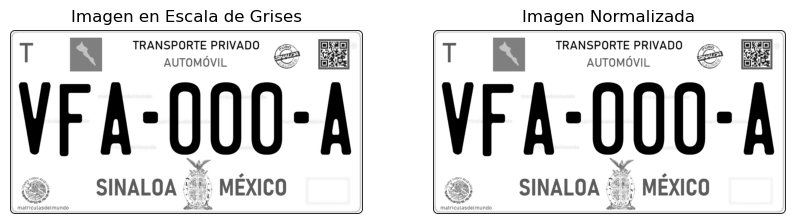

In [365]:
def normalize_image(image):
    """Normaliza la imagen para que los valores estén entre 0 y 255."""
    norm_image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)
    return norm_image.astype(np.uint8)

normalized_image = normalize_image(gray_image)
plotImages(gray_image, normalized_image, 'Imagen en Escala de Grises', 'Imagen Normalizada')

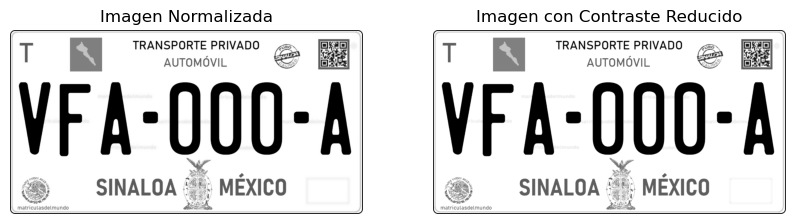

In [366]:
def decrease_contrast(image):
    """Disminuye el contraste de la imagen."""
    alpha = 0.15  # Ajustar este valor para reducir el contraste, debe ser menor que 1
    beta = 100    # Ajustar este valor para ajustar el brillo
    return cv2.convertScaleAbs(image, alpha=alpha, beta=beta)

# Aplicar la reducción de contraste a la imagen normalizada
low_contrast_image = decrease_contrast(normalized_image)

# Mostrar las imágenes antes y después de reducir el contraste
plotImages(normalized_image, low_contrast_image, 'Imagen Normalizada', 'Imagen con Contraste Reducido')


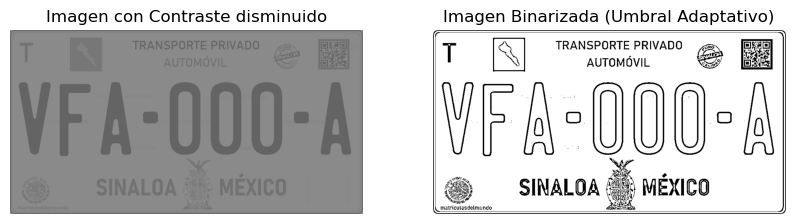

In [367]:
def adaptive_threshold_edges(image):
    """Aplica umbral adaptativo para binarizar la imagen."""
    return cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 13, 2)


binary_image = adaptive_threshold_edges(low_contrast_image)
plotImages(low_contrast_image, binary_image, 'Imagen con Contraste disminuido', 'Imagen Binarizada (Umbral Adaptativo)')

In [368]:
def conv_helper(fragment, kernel):
    """Multiplica dos matrices y devuelve su suma."""
    return np.sum(fragment * kernel)

def convolution(image, kernel, padding=True):
    """Aplica una convolución con opción de padding."""
    image_row, image_col = image.shape
    kernel_row, kernel_col = kernel.shape

    # Calcula padding.
    pad_height = (kernel_row - 1) // 2
    pad_width = (kernel_col - 1) // 2

    # Aplica padding si es necesario.
    if padding:
        padded_image = np.zeros((image_row + 2 * pad_height, image_col + 2 * pad_width))
        padded_image[pad_height:-pad_height, pad_width:-pad_width] = image
    else:
        padded_image = image

    output_row = image_row if padding else (image_row - kernel_row + 1)
    output_col = image_col if padding else (image_col - kernel_col + 1)
    output = np.zeros((output_row, output_col))

    # Aplica la convolución.
    for row in range(output_row):
        for col in range(output_col):
            fragment = padded_image[row:row + kernel_row, col:col + kernel_col]
            output[row, col] = conv_helper(fragment, kernel)

    return output

# Definimos la función para normalizar la imagen después de aplicar el filtro.
def normalize_image(image):
    """Normaliza la imagen para que los valores estén entre 0 y 255."""
    norm_image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)
    return norm_image.astype(np.uint8)

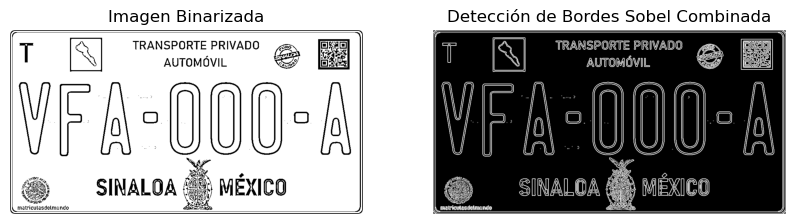

In [369]:
# Definir los filtros de convolución
filters = {
    'sobel_vertical': np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]),
    'sobel_horizontal': np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]]),
    'laplacian': np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]]),
    'edge_detection': np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]]),
    'gaussian_blur': np.array([[0, 0, 0, 5, 0, 0, 0],
                               [0, 5, 18, 32, 18, 5, 0],
                               [0, 18, 64, 100, 64, 18, 0],
                               [5, 32, 100, 100, 100, 32, 5],
                               [0, 18, 64, 100, 64, 18, 0],
                               [0, 5, 18, 32, 18, 5, 0],
                               [0, 0, 0, 5, 0, 0, 0]])
}

# Aplicar Sobel Vertical y Horizontal para destacar los bordes
sobel_vertical_image = convolution(binary_image, filters['sobel_vertical'])
sobel_horizontal_image = convolution(binary_image, filters['sobel_horizontal'])

# Combinar los bordes verticales y horizontales usando la magnitud del gradiente
combined_edges_image = np.sqrt(sobel_vertical_image**2 + sobel_horizontal_image**2)
combined_edges_image = normalize_image(combined_edges_image)

# Mostrar los resultados
plotImages(binary_image, combined_edges_image, 'Imagen Binarizada', 'Detección de Bordes Sobel Combinada')


Location:  [[[  0   0]]

 [[  0 521]]

 [[999 521]]

 [[999   0]]]


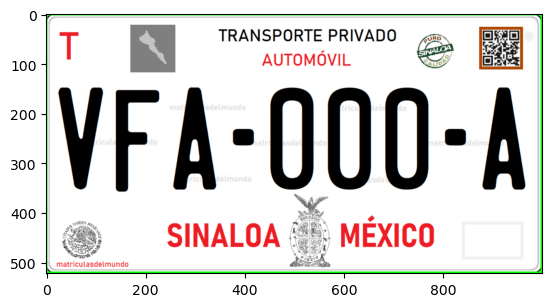

In [370]:
def extract_characters(closed_image, original_image):
    keypoints = cv2.findContours(closed_image.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) #Find contours 
    contours = imutils.grab_contours(keypoints) #Grab contours 
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10] #Sort contours
    
    #Loop over our contours to find the best possible approximate contour of 10 contours
    location = None
    for contour in contours:
        approx = cv2.approxPolyDP(contour, 10, True)
        if len(approx) == 4:
            location = approx
            break
         
    print("Location: ", location)
    
    mask = np.zeros(low_contrast_image.shape, np.uint8) #create blank image with same dimensions as the original image
    new_image = cv2.drawContours(mask, [location], 0,255, -1) #Draw contours on the mask image
    new_image = cv2.bitwise_and(image, image, mask=mask) #Take bitwise AND between the original image and mask image
    
    plt.imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB)) #show the final imag
    
    (x,y) = np.where(mask==255) #Find the co-ordinates of the four corners of the document
    (x1, y1) = (np.min(x), np.min(y)) #Find the top left corner
    (x2, y2) = (np.max(x), np.max(y)) #Find the bottom right corner
    cropped_image = normalized_image[x1:x2+1, y1:y2+1] #Crop the image using the co-ordinates

    plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB)) #show the cropped image
    
    reader = easyocr.Reader(['en']) #create an easyocr reader object with english as the language
    result = reader.readtext(cropped_image) #read text from the cropped image
    result
    
    text = result[0][-2] #Extract the text from the result
    font = cv2.FONT_HERSHEY_SIMPLEX #Font style
    res = cv2.putText(image, text=text, org=(approx[0][0][0], approx[1][0][1]+60), fontFace=font, fontScale=1, color=(0,255,0),thickness=2, lineType=cv2.LINE_AA) #put the text on the image
    res = cv2.rectangle(image, tuple(approx[0][0]), tuple(approx[2][0]), (0,255,0),3) #Draw a rectangle around the text

    plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB)) #show the final image with text

extract_characters(combined_edges_image, image)